# From Google Earth to a geological model

## Import

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import mplstereonet
from importlib import reload

import sys
import os
sys.path.append(r"..")  # append local path to access rgeomod module
import rgeomod

## Import, process and visualize Google Earth data

### Load .kml files

#### Danielle 1

In [34]:
filepath = "../data/danielle/1/"

In [35]:
ks = []
for i, fn in enumerate(os.listdir(filepath)):
    if ".kml" in fn:
        print(fn)
        ks.append(rgeomod.kml_to_plane.KmlPoints(filename=filepath+fn, debug=True))
        print("\n")

01_naith_form_contacts.kml
read kml
6 point sets added


01_naith_form_dips.kml
read kml
27 point sets added


02_nahr_umr_form_contacts.kml
read kml
3 point sets added


03_shuaiba_form_contacts.kml
read kml
2 point sets added


03_shuaiba_form_dips.kml
read kml
12 point sets added


04_kharaib_form_contacts.kml
read kml
1 point sets added


04_kharaib_form_dips.kml
read kml
5 point sets added




#### FW1

#### Simple Example

### Get formation names

In [36]:
ks_names = [s[:-4] for s in os.listdir(filepath)]
ks_names

['01_naith_form_contacts',
 '01_naith_form_dips',
 '02_nahr_umr_form_contacts',
 '03_shuaiba_form_contacts',
 '03_shuaiba_form_dips',
 '04_kharaib_form_contacts',
 '04_kharaib_form_dips',
 '']

In [37]:
dips_bool = []
for name in ks_names:
    if "dips" in name:
        dips_bool.append(1)
    else:
        dips_bool.append(0)
        
dips_bool = np.array(dips_bool).astype(bool)
dips_bool

array([False,  True, False, False,  True, False,  True, False], dtype=bool)

### Check point sets to have at least 3 points for plane fit

In [38]:
for k in ks:
    rgeomod.check_point_sets(k)

### Load DTM to obtain elevation data and fit planes

In [39]:
# try to get elevation data from DTM geotiff
# if data points are located outside of the geotiff's extent, drop the point set
for k in ks:
    for ps in k.point_sets:
        try:
            ps.get_z_values_from_geotiff("../data/dome_sub_sub_utm.tif")
        except IndexError:
            print("Point outside geotiff, drop")
            k.point_sets.remove(ps)
            continue

        # convert LatLon coordinates to UTM
        ps.latlong_to_utm()
        # Fit plane to point set
        ps.plane_fit()

### Visualize points in 3D

* [TODO] Make 3d point plot nicer (color for units)

In [40]:
ks_coords = []
for k in ks:
    ks_coords.append(rgeomod.extract_xyz(k))

Text(0.5,0.92,'GoogleEarth picks')

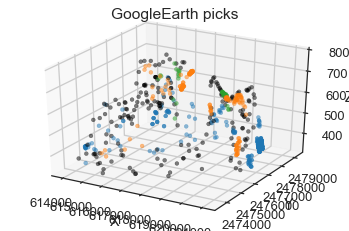

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# colors = ["black", "yellow", "red", "green", "purple"]

for i, k in enumerate(ks_coords):
    if dips_bool[i]:
        ax.scatter(k[0],k[1],k[2], alpha=0.5, s=15, label=ks_names[i])
    else:
        ax.scatter(k[0],k[1],k[2], color="black", alpha=0.5, s=15, label=ks_names[i])
#ax.legend()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("GoogleEarth picks")

### Determine dip angles and dip diretions

In [42]:
# create storage lists
dips = []
dip_dirs = []
dip_xs = []
dip_ys = []
dip_zs = []

# loop over all point sets, determine dip angle and dip direction and append them to storage lists
for k in ks:
    for ps in k.point_sets:
        
        # determine dip angle from normal vector of plane
        dips.append(rgeomod.dip(ps.normal)) 
        # get dip direction from normal vector
        dip_dirs.append(rgeomod.dip_dir(ps.normal))
        # get centroid coordinates
        dip_xs.append(ps.ctr.x)
        dip_ys.append(ps.ctr.y)
        dip_zs.append(ps.ctr.z)

Plot histograms of the extracted dip and dip direction data:

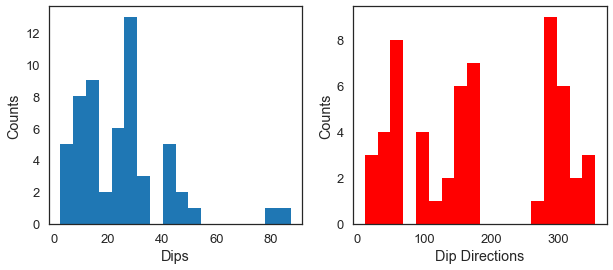

In [43]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(dips, 18)
ax1.set_xlabel("Dips")
ax1.set_ylabel("Counts")
ax2.hist(dip_dirs, 18, color='r');
ax2.set_xlabel("Dip Directions")
ax2.set_ylabel("Counts");

### Stereonet Plots

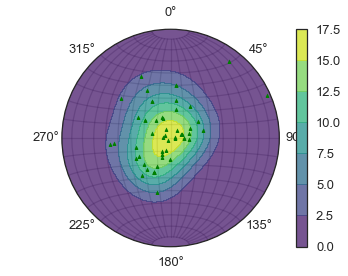

In [44]:
fig, ax = mplstereonet.subplots()
cax = ax.density_contourf(dip_dirs, dips, measurement='poles', cmap='viridis', alpha=0.75)
fig.colorbar(cax)
ax.pole(dip_dirs, dips, 'g^', markersize=4)
ax.grid(True, color="black", alpha=0.25)

plt.show()

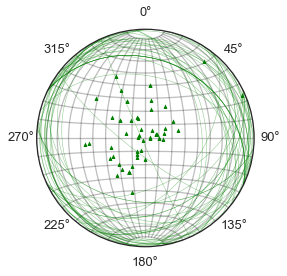

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
ax.pole(dip_dirs, dips, 'g^', markersize=4)
ax.plane(dip_dirs, dips, 'g-', linewidth=0.5, alpha=0.45)
ax.grid(True, color="black", alpha=0.25)

# To GemPy dataframe

## Interfaces

In [46]:
dips_bool

array([False,  True, False, False,  True, False,  True, False], dtype=bool)

In [47]:
ks_coords_interf = []
ks_names_interf = []
for i, k in enumerate(ks_coords):
    if not dips_bool[i]:
        ks_coords_interf.append(k)
        ks_names_interf.append(ks_names[i])

In [48]:
interf_filter = np.where(dips_bool==False)[0].astype(int)
interf = rgeomod.points_to_gempy_interf(ks_coords_interf, ks_names_interf)

In [49]:
interf.tail()

,X,Y,Z,formation,series
186,619020.682901,2.477096e+06,671.0,04_kharaib_form_contacts,Default series
187,619376.472394,2.477006e+06,601.0,04_kharaib_form_contacts,Default series
188,619906.303350,2.476771e+06,536.0,04_kharaib_form_contacts,Default series
189,620149.357382,2.476377e+06,482.0,04_kharaib_form_contacts,Default series
190,620252.591736,2.476208e+06,383.0,04_kharaib_form_contacts,Default series


## Foliations

In [50]:
fols = rgeomod.dips_to_gempy_fol(dips, dip_dirs, dip_xs, dip_ys, dip_zs, "10_mahil_form_contacts")

In [51]:
fols.tail()

,X,Y,Z,dip,azimuth,polarity,formation,series
51,619063.822806,2.477362e+06,634.350000,5.454924,11.664136,1,10_mahil_form_contacts,Default series
52,616501.429951,2.477704e+06,682.125000,27.597101,315.480637,1,10_mahil_form_contacts,Default series
53,617113.127234,2.475674e+06,743.333333,10.131317,181.994974,1,10_mahil_form_contacts,Default series
54,617761.888764,2.475776e+06,610.333333,28.359115,120.868013,1,10_mahil_form_contacts,Default series
55,619438.590048,2.477128e+06,582.000000,17.589164,51.358798,1,10_mahil_form_contacts,Default series


## Save to .csv files

In [52]:
interf.to_csv("gempy_interfaces.csv", index=False)
fols.to_csv("gempy_foliations.csv", index=False)

# GemPy

In [53]:
# These two lines are necessary only if gempy is not installed
sys.path.append("../../gempy/")
sys.path.append("../gempy/")

# Importing gempy
import gempy as gp


In [54]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], 
                        path_f = "gempy_foliations.csv",
                        path_i = "gempy_interfaces.csv")

../../gempy\gempy\DataManagement.py:427: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../../gempy\gempy\DataManagement.py:430: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


In [83]:
geo_data.foliations = geo_data.foliations.drop(np.where(geo_data.foliations.duplicated("X").values==True)[0])

In [84]:
ks_names_interf

['01_naith_form_contacts',
 '02_nahr_umr_form_contacts',
 '03_shuaiba_form_contacts',
 '04_kharaib_form_contacts']

../../gempy\gempy\DataManagement.py:427: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../../gempy\gempy\DataManagement.py:430: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


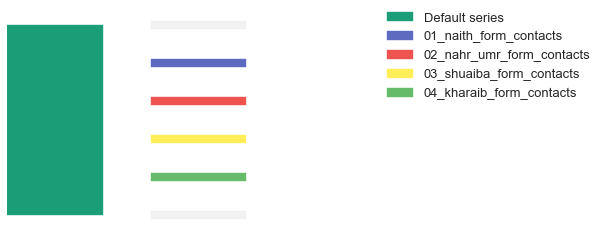

In [85]:
gp.set_series(geo_data, {"Default series": tuple(ks_names_interf)},
             order_formations = ks_names_interf)

## Data visualization

### 2D

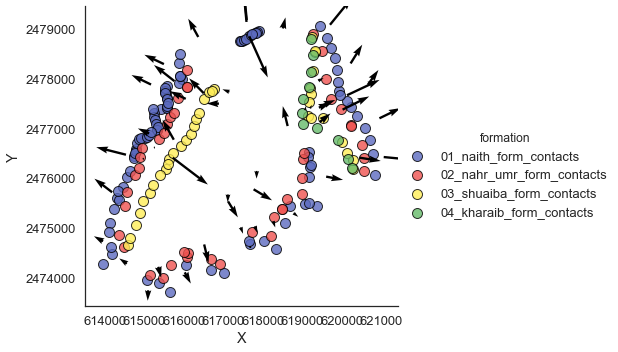

In [86]:
gp.plot_data(geo_data, direction="z")

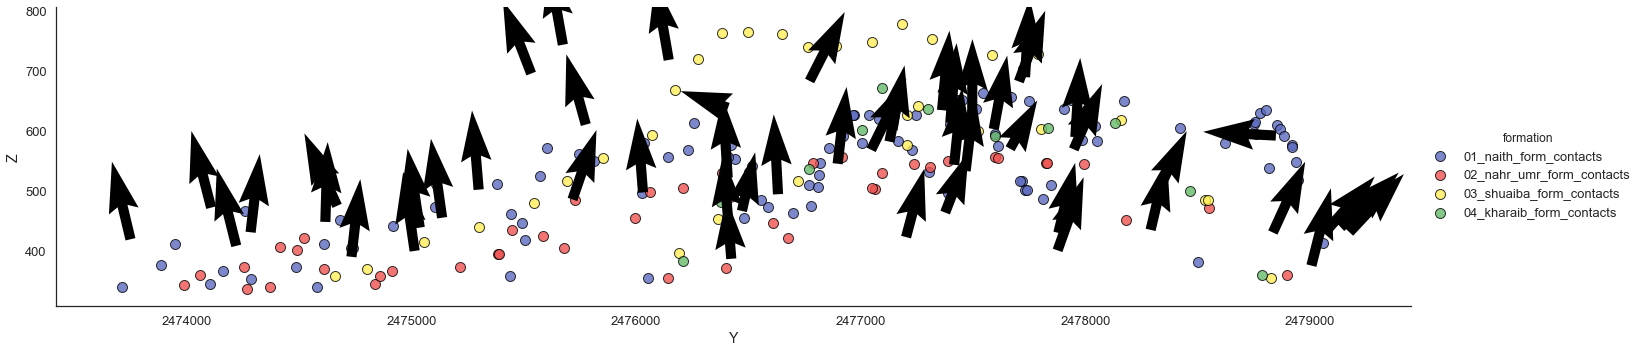

In [87]:
gp.plot_data(geo_data, direction="x")

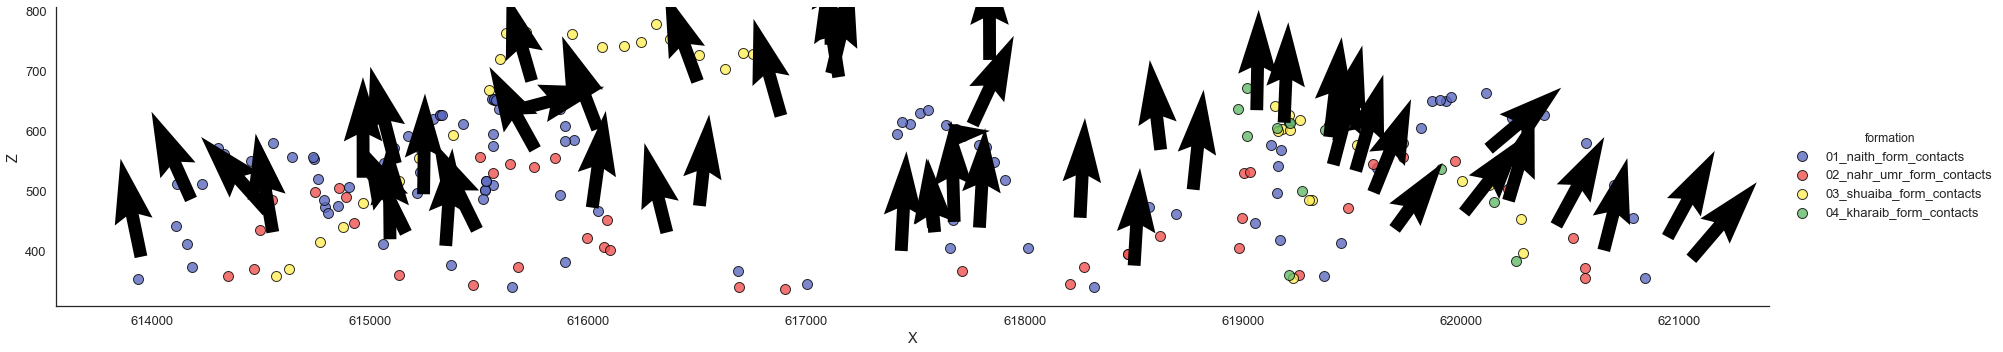

In [88]:
gp.plot_data(geo_data, direction="y")

### 3D (requires VTK)

In [89]:
gp.plot_data_3D(geo_data)

## Computing the 3D model

Instantiate interpolator

In [90]:
interp_data = gp.InterpolatorInput(geo_data)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


Compute

In [91]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\ProgramData\Anaconda3\envs\googlepicks\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.3189249959431066e-11 / 5.960464477539063e-08
  RuntimeWarning)


## Model visualization

### 2D Sections

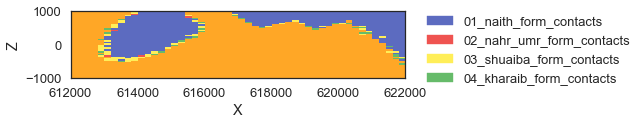

In [92]:
gp.plot_section(geo_data, lith_block[0], 40, direction='y')

### 3D Surfaces (requires VTK)

In [32]:
v_l, s_l = gp.get_surfaces(interp_data, potential_lith=lith_block[1])
gp.plot_surfaces_3D(geo_data, v_l, s_l)

### Pseudo-3D point clouds

Text(0.5,0,'Z')

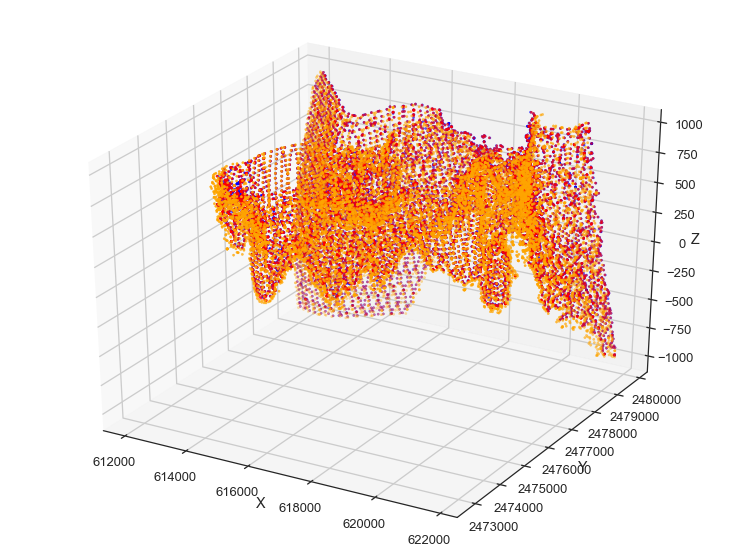

In [93]:
v_l, s_l = gp.get_surfaces(interp_data, potential_lith=lith_block[1])

%matplotlib inline
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')

cs = ["blue", "red", "orange"]
for i in range(3):
    ax.scatter(v_l[i][:,0],v_l[i][:,1],v_l[i][:,2], c=cs[i], s=5)
    
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")